In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import datetime

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   
from glob import glob
import h5py

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=10,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

In [4]:
eui_files = sorted(glob("../../src/EUI/HRI/euv174/20221024/coalign_step/*.fits"))
eui_map_seq_coalign = sunpy.map.Map(eui_files[:],sequence=True,memmap=True)

In [5]:
Txshift_hri, Tyshift_hri = (1.66986 + 2.49223)*u.arcsec,(7.60204 - 2.76366 )*u.arcsec

map_181 = eui_map_seq_coalign[181].shift_reference_coord(Txshift_hri,Tyshift_hri)
map_181.meta["rsun_ref"] = 696000000.0

phi_los_map = sunpy.map.Map("../../src/coalign_map/20221024/phi_los_map_shifted.fits")
phi_los_map_hrifov = phi_los_map.reproject_to(map_181.wcs)

In [6]:
def plot_eui_stddev_and_phi(eui_map,phi_los_map,eis_vel_map,bottom_left,top_right,
                        eui_norm,phi_norm,cv_norm=ImageNormalize(vmin=0,vmax=0.25)):
    
    eui_map_array = np.zeros((len(eui_map),(top_right[1]-bottom_left[1]+1*u.pix).value.astype(np.int32),(top_right[0]-bottom_left[0]+1*u.pix).value.astype(np.int32)))
    
    for ii, map_ in enumerate(eui_map[:]):
        eui_map_array[ii,:,:] = map_.submap(bottom_left,top_right=top_right).data
    
    eui_map_array_mean = np.nanmean(eui_map_array,axis=0)
    eui_map_array_std = np.nanstd(eui_map_array,axis=0)
    eui_map_array_cv = eui_map_array_std/eui_map_array_mean

    del eui_map_array

    phi_los_map_cutout = phi_los_map.submap(bottom_left,top_right=top_right)
    eui_map_181_crop = map_181.submap(bottom_left,top_right=top_right)

    fig = plt.figure(figsize=(10,5),layout="constrained")

    ax1 = fig.add_subplot(131,projection=eui_map_181_crop)
    ax2 = fig.add_subplot(132,projection=eui_map_181_crop)
    ax3 = fig.add_subplot(133,projection=eui_map_181_crop)

    eui_map_181_crop.plot(axes=ax1,norm=eui_norm)

    im2 = ax2.imshow(eui_map_array_cv,cmap="Greys",origin="lower",norm=cv_norm)
    ax2.set_title(r"HRI 17.4 nm $\sigma/\mu$")

    im3 = phi_los_map_cutout.plot(axes=ax3,norm=phi_norm,cmap="hmimag",
                title="PHI Blos 2022-10-24 19:15:03")
    
    clb2, clb_ax2 = plot_colorbar(im2,ax2,width="5%")
    clb3, clb_ax3 = plot_colorbar(im3,ax3,width="5%")

    ax2.set_ylabel(' ')
    ax3.set_ylabel(' ')

    for ax_ in (ax1,ax2,ax3):
        bounds = ax_.axis()
        eis_vel_map.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                axes=ax_)
        ax_.axis(bounds)




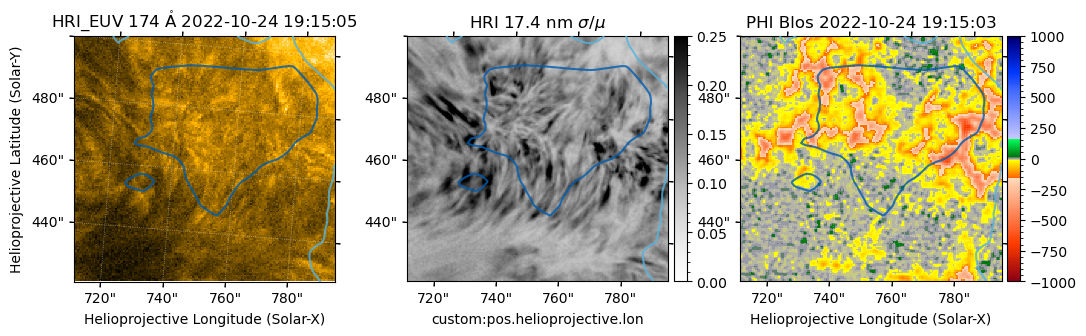

In [7]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [500,600]*u.pix,[670,760]*u.pix,
                            ImageNormalize(vmin=150,vmax=1.5e3,stretch=AsinhStretch(0.4)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

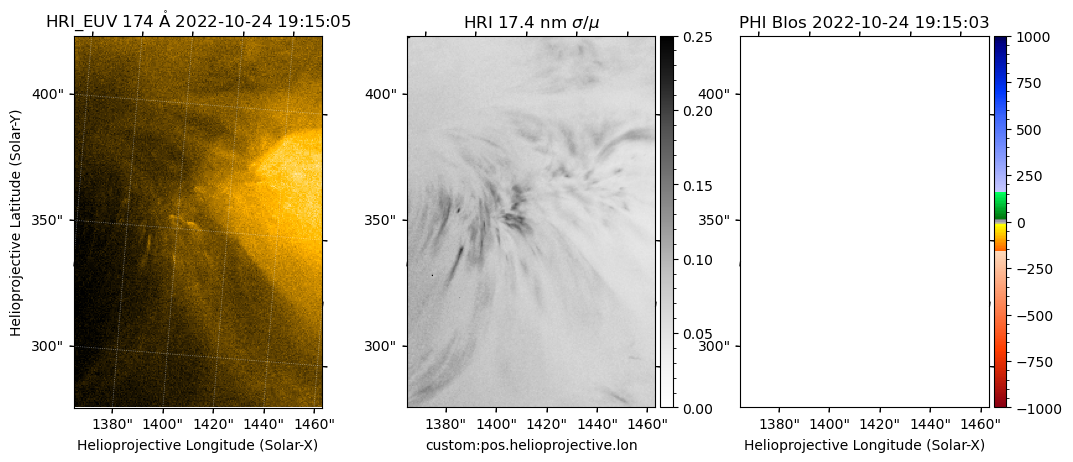

In [8]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [1800,200]*u.pix,[2000,500]*u.pix,
                            ImageNormalize(vmin=300,vmax=2.7e3,stretch=AsinhStretch(0.4)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

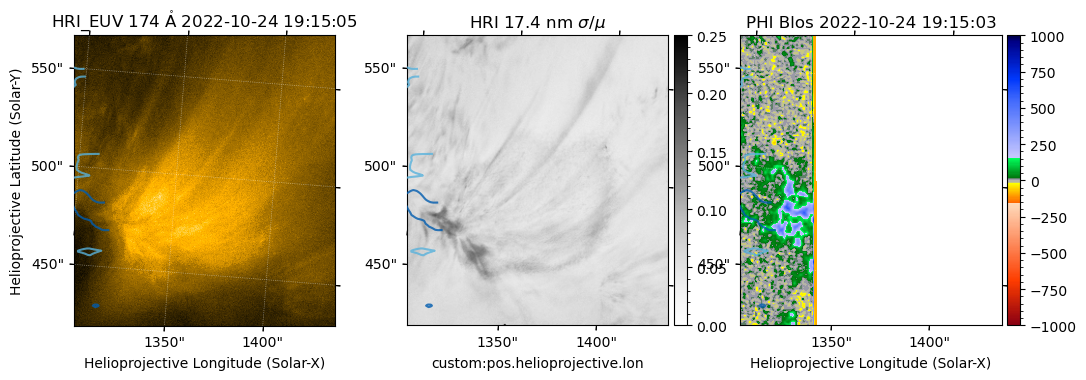

In [9]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [1700,500]*u.pix,[1970,800]*u.pix,
                            ImageNormalize(vmin=500,vmax=6e3,stretch=AsinhStretch(0.4)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

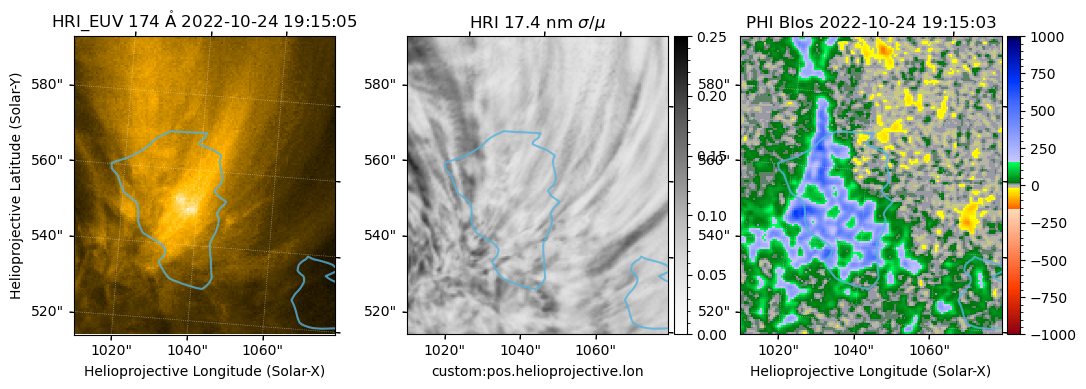

In [10]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_hhflare_195_velmap_derot_repro_hrifov,
                            [1120,740]*u.pix,[1260,900]*u.pix,
                            ImageNormalize(vmin=5e2,vmax=1.2e4,stretch=AsinhStretch(0.4)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

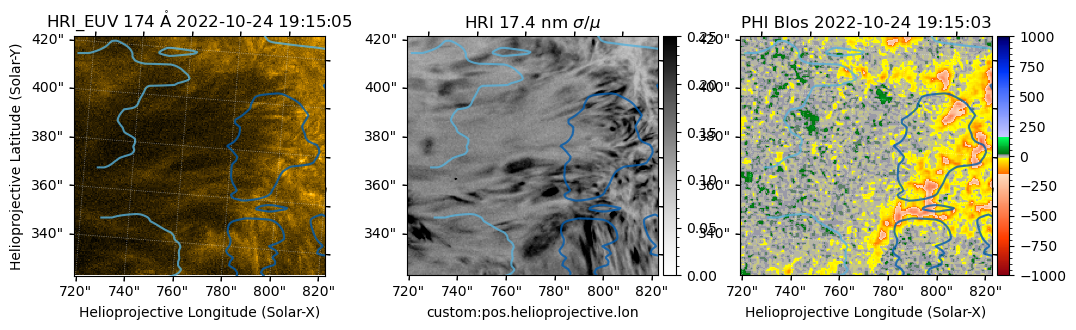

In [11]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [500,400]*u.pix,[710,600]*u.pix,
                            ImageNormalize(vmin=100,vmax=1.5e3,stretch=AsinhStretch(0.4)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

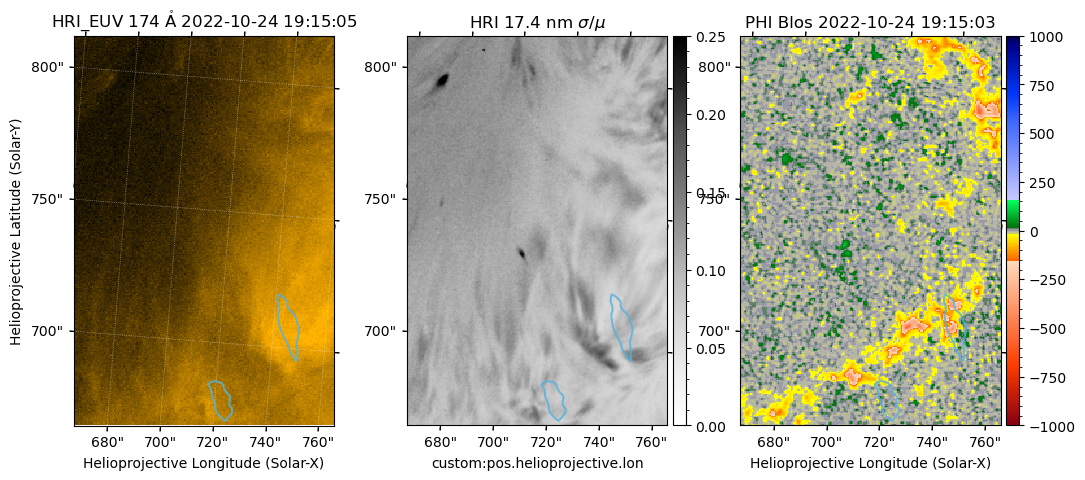

In [12]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [450,1100]*u.pix,[650,1400]*u.pix,
                            ImageNormalize(vmin=100,vmax=4e3,stretch=AsinhStretch(0.1)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

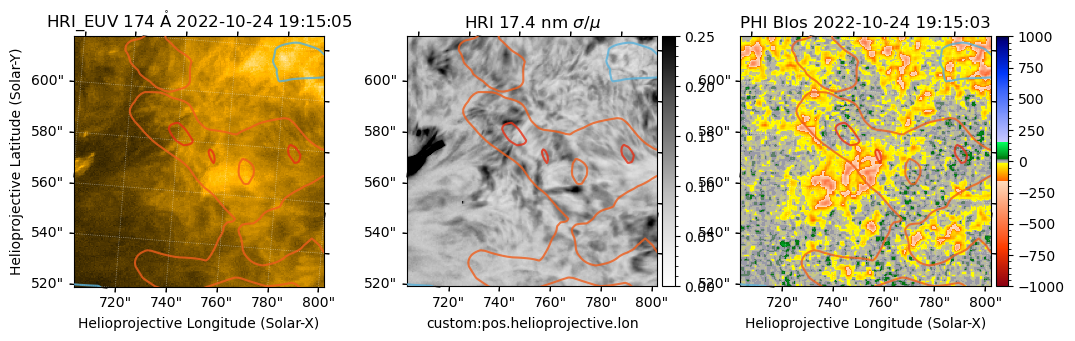

In [13]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [500,800]*u.pix,[700,1000]*u.pix,
                            ImageNormalize(vmin=100,vmax=8e3,stretch=AsinhStretch(0.1)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

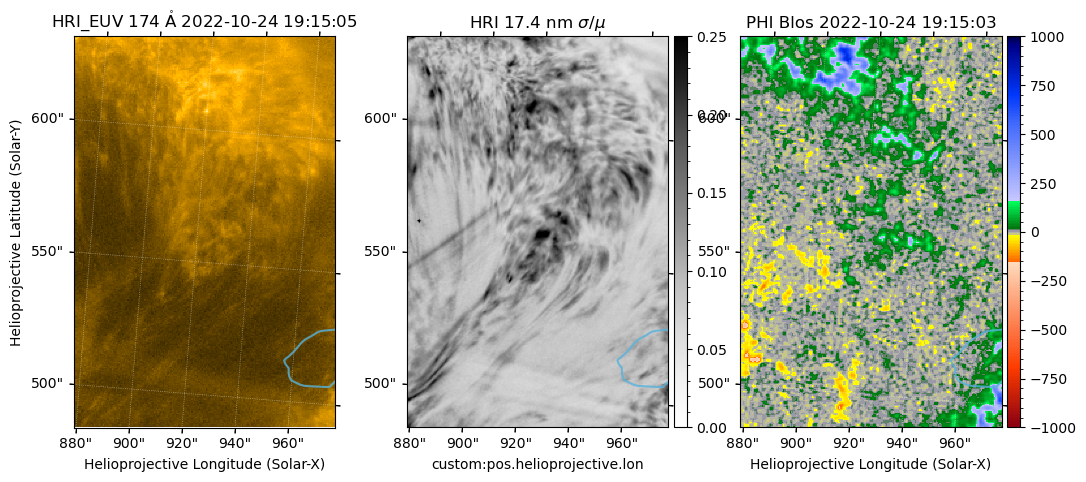

In [14]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [850,700]*u.pix,[1050,1000]*u.pix,
                            ImageNormalize(vmin=100,vmax=7e3,stretch=AsinhStretch(0.1)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

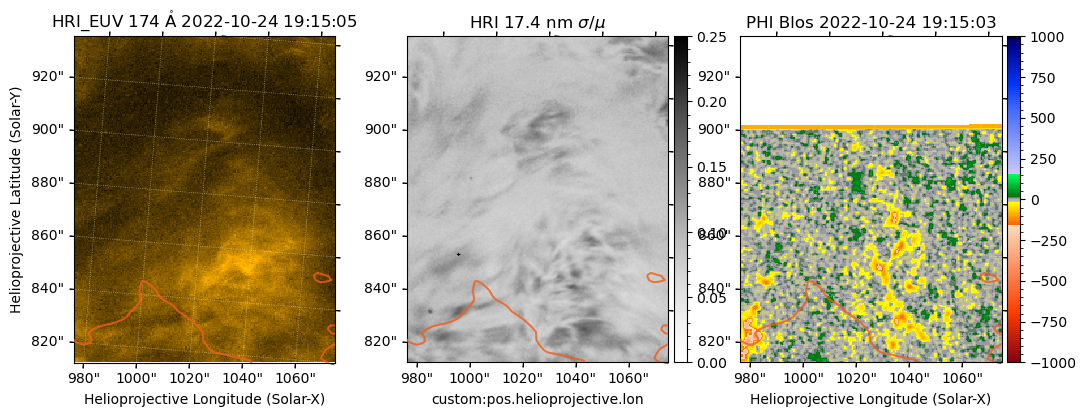

In [15]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [1100,1350]*u.pix,[1300,1600]*u.pix,
                            ImageNormalize(vmin=250,vmax=3e3,stretch=AsinhStretch(0.3)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

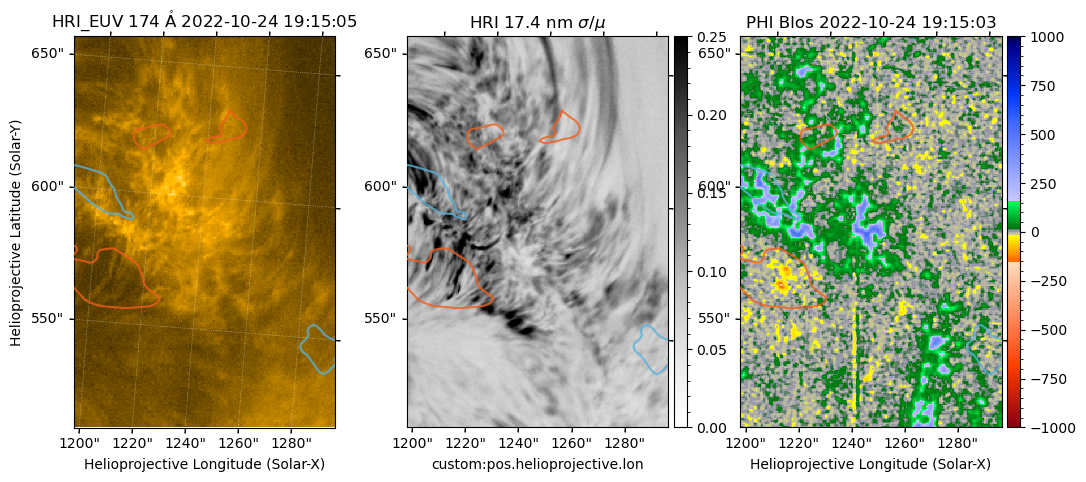

In [16]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [1500,700]*u.pix,[1700,1000]*u.pix,
                            ImageNormalize(vmin=100,vmax=7e3,stretch=AsinhStretch(0.1)),
                            ImageNormalize(vmin=-1000,vmax=1000),)

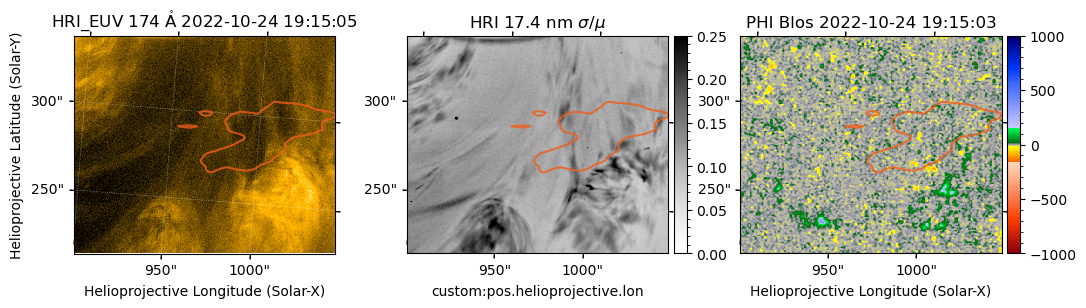

In [17]:
plot_eui_stddev_and_phi(eui_map_seq_coalign,phi_los_map_hrifov,eis_195_velmap_derot_repro_shifted_hrifov,
                            [850,150]*u.pix,[1150,400]*u.pix,
                            ImageNormalize(vmin=150,vmax=2e3,stretch=AsinhStretch(0.15)),
                            ImageNormalize(vmin=-1000,vmax=1000),)